<h1 align="center">MSIN0097: Predictive Analytics</h1>
<h1 align="center">Individual Assignment</h1>
<h1 align="center">RFM Customer Segmentation of a Cosmetic E-commerce with DBSCAN, K-means and GMM</h1>
<br>

<h3>Table of Contents</h3>

* [1. Introduction](#1.-Introduction)
    * [1.1 Data Overview](#1.2-Data-Overview)
* [2. Dataset](#2.-Dataset)
    * [2.1. Data Cleaning](#2.1-Data-Cleaning)
    * [2.2. Parsing Datetime and Creating Datetime Related Columns](#2.2-Parsing-Datetime-and-Creating-Datetime-Related-Columns)
* [3. Exploring the Data](#3.-Exploring-the-Data)
    * [3.1. Data Visualisation](#3.1-Data-Visualisation)
* [4. RFM Analysis](#5.-RFM-Analysis)
* [5. Normalisation, Skew Test and Models](#6.-Normalisation,-Skew-Test-and-Models)
    * [5.1. DBSCAN](#5.1-DBSCAN)
    * [5.2. K-means](#5.2-K-means)
    * [5.3. Gaussian Mixture Model (GMM)](#5.3-Gaussian-Mixture-Model-(GMM))
    * [5.4 Evaluation of the Models: Silhouette Score](#5.4-Evaluation-of-the-Models:-Silhouette-Score)
* [6. Conclusion](#6.-Evaluation)
    * [6.1. Limitations and Future Improvements](#6.1-Limitations-and-Future-Improvements)
* [References](#References)
* [Appendix A](#Appendix-A)

## Introduction

Customer segmentation is about finding a group of customers, understanding their characteristics and use that to improve profitability. The characteristics that often businesses use to understand customers' characteristics include demogaphics, choices, interests, purchasing patterns and purchasing power. However, in this project I will explore customer segmentation deeper than surface-level attributes such as demographics - I will attempt to utilise RFM. 

The RFM analysis is defined as a marketing analysis tool used to identify a an organization's best and worst customers through measurement of spending habits (Segal, 2021). The RFM analysis essentially looks at 3 features; Recency, Frequency and Monetary. Recency refers to how recent did this customer interract with us, Frequency refers to how frequent the interraction happens and lastly, Monetary refers to the monetary value that the customer is involved in. Hence, the best customer would ideally have a low recency, high frequency and high monetary.

In this project, I aim to implement unsupervised clustering machine learning models to perform clustering analysis in regard to customer segmentation to discover groups of similar customers. Clustering algorithms work by identifying variations among customers within the different cluster or groups. My goal with this clustering customer segmentations is to precisely categorise customers in order to gain a more effetive and personalised customer marketing. This project will explore DBSCAN clustering, K-means clustering and GMM clustering, with application of theories and moethodologies including inertia, distortions and Bartlett's Test.

This project aims to evaluate the interpretability, usability and the robustness of the model in a real-life dataset. Hence, a large part of the evaluation will be based on how interpretable and useful it is within a business/marketing perspective. 

### 1.1 Data Overview

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Base
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import os
import statsmodels.api as sm
import datetime
import random
from scipy import stats
from scipy.spatial.distance import cdist
from tqdm import tqdm

#Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.cluster import Birch
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from feature_engine.outliers import Winsorizer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

#Visualisations
import plotly.express as px 
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sns.set(rc={'font.size': 20, 'axes.titlesize': 20, 'axes.labelsize':20})
vcvtype = 'nonrobust'

In [2]:
# Load the ecommerce data for Oct19 - Feb20
data = pd.read_csv("2019-Oct.csv", low_memory=False)
#nov19 = pd.read_csv("2019-Nov.csv", low_memory=False)
#dec19 = pd.read_csv("2019-Dec.csv", low_memory=False)
#jan20 = pd.read_csv("2020-Jan.csv", low_memory=False)
#feb20 = pd.read_csv("2020-Feb.csv", low_memory=False)

In [3]:
data.head()

event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       cart     5773203  1487580005134238553   
1  2019-10-01 00:00:03 UTC       cart     5773353  1487580005134238553   
2  2019-10-01 00:00:07 UTC       cart     5881589  2151191071051219817   
3  2019-10-01 00:00:07 UTC       cart     5723490  1487580005134238553   
4  2019-10-01 00:00:15 UTC       cart     5881449  1487580013522845895   

  category_code   brand  price    user_id  \
0           NaN  runail   2.62  463240011   
1           NaN  runail   2.62  463240011   
2           NaN  lovely  13.48  429681830   
3           NaN  runail   2.62  463240011   
4           NaN  lovely   0.56  429681830   

                           user_session  
0  26dd6e6e-4dac-4778-8d2c-92e149dab885  
1  26dd6e6e-4dac-4778-8d2c-92e149dab885  
2  49e8d843-adf3-428b-a2c3-fe8bc6a307c9  
3  26dd6e6e-4dac-4778-8d2c-92e149dab885  
4  49e8d843-adf3-428b-a2c3-fe8bc6a307c9

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4102283 entries, 0 to 4102282
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 281.7+ MB


Due to constraints of compute power, as there are more than 20 million rows in data_full, I will create a random subset containing some data from each of the 5 datasets. For now, it is assumed that a random subsetting will remain to be representative of data_full

In [5]:
data.isnull().sum()/len(data)

event_time       0.000000
event_type       0.000000
product_id       0.000000
category_id      0.000000
category_code    0.983551
brand            0.404473
price            0.000000
user_id          0.000000
user_session     0.000155
dtype: float64

This signifies that 98% of data under category_code and 42% of data under brand is missing. As these columns have majority null values, and hence would not add to the analysis, these two columns will be removed. For the missing user_session, I will also remove the rows where null values are present. 

In [6]:
data["price"].describe()

count    4.102283e+06
mean     8.534920e+00
std      1.913315e+01
min     -7.937000e+01
25%      2.140000e+00
50%      4.110000e+00
75%      7.140000e+00
max      3.076000e+02
Name: price, dtype: float64

By describing the price column I was able to deduce that there are negative values in the dataset. This gives me an insight that the dataset not only contain purchases, basket and view activities, it also records returns and refunds.

In [7]:
returns=data[data['price']<0]['price'].count()
returns_percentage=returns/(data['price'].count())
print(returns)
print(returns_percentage)

20
4.875334051795061e-06


By running this test, I noticed that the number of negative values in 'price'- in which I initially thought were returns or refunds, were insignificant. This redirected my previous assumptions of the negative values being returns and refunds, to the negative values being an input error. For these reasons, I will remove the 131 negative values. 

In [8]:
data['event_type'].unique()

array(['cart', 'view', 'remove_from_cart', 'purchase'], dtype=object)

From viewing the unique values in event_type I learn that there are 4 different event types that are recorded in the dataset, they are: view, cart, remove from cart and purchase. For now, I will assume that "view" is to view an item, "cart" is to add something to the cart, "remove_from_cart" is to remove from cart and "purchase" is to purchase the item.

In [9]:
data['product_id'].nunique()
data['category_id'].nunique()

41899

490

In [10]:
data['user_id'].nunique()
data['user_session'].nunique()

399664

873960

from viewing unique values in user_id and user_session, I learn that one user_id can have multiple sessions.

## 2.0 Dataset

|**Variables**   |  **Description**  |
|:---| :---|
| **`event_time`** | Datetime format of the time that an e-commerce activity occur |
| **`event_type`** | View, Cart, Remove from Cart and Purchase |
| **`product_id`** | Unique identifier for each product |
| **`category_id`** | Unique identifier for each category. Multiple `product_id` can have one `category_id` |
| **`category_code`** | Code for category names. Mostly null. |
| **`brand`** | Brand of the item |
| **`price`** | Price in unit of currency |
| **`user_id`** | Unique identifier for each user |
| **`user_session`** | Unique identifier for each e-commerce session, one `user_id` can have multiple `user_session` |

### 2.1 Data Cleaning

In [11]:
data = data.drop(["category_code", "brand"], axis = 1)

In [12]:
data.dropna(inplace=True)

In [13]:
data.drop(data[data['price'] < 0].index, inplace = True)

In [14]:
data['price'].describe()

count    4.101626e+06
mean     8.535176e+00
std      1.913340e+01
min      0.000000e+00
25%      2.140000e+00
50%      4.110000e+00
75%      7.140000e+00
max      3.076000e+02
Name: price, dtype: float64

In [15]:
data.head()
data.shape

event_time event_type  product_id          category_id  price  \
0  2019-10-01 00:00:00 UTC       cart     5773203  1487580005134238553   2.62   
1  2019-10-01 00:00:03 UTC       cart     5773353  1487580005134238553   2.62   
2  2019-10-01 00:00:07 UTC       cart     5881589  2151191071051219817  13.48   
3  2019-10-01 00:00:07 UTC       cart     5723490  1487580005134238553   2.62   
4  2019-10-01 00:00:15 UTC       cart     5881449  1487580013522845895   0.56   

     user_id                          user_session  
0  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885  
1  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885  
2  429681830  49e8d843-adf3-428b-a2c3-fe8bc6a307c9  
3  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885  
4  429681830  49e8d843-adf3-428b-a2c3-fe8bc6a307c9

(4101626, 7)

### 2.2 Parsing Datetime and Creating Datetime Related Columns

In [16]:
#seperating timezone
data["timezone"]= data["event_time"].str.rsplit(" ", n=1,expand = True)[1]
data["event_time"]= data["event_time"].str.rsplit(" ", n=1,expand = True)[0]
data["event_time"]=pd.to_datetime(data["event_time"])

#creating date,time,hours,weekday,weeknum columns
data['date']=data['event_time'].dt.date
data['year']=data['event_time'].dt.year
data['month']=data['event_time'].dt.month
data['day']=data['event_time'].dt.day
data['time']=data['event_time'].dt.time
data['hours']=data['event_time'].dt.hour
data['minutes']=data['event_time'].dt.minute
data['seconds']=data['event_time'].dt.second
data['weekday']=data['event_time'].dt.weekday
data['weeknum']=data['event_time'].dt.isocalendar().week

#changing weekday to string and adding 'week_' prefix to weeknum
data['weekday']= data['weekday'].replace({0:'Mon',1:'Tues',2:'Wed',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'})

In [17]:
data.head()

event_time event_type  product_id          category_id  price  \
0 2019-10-01 00:00:00       cart     5773203  1487580005134238553   2.62   
1 2019-10-01 00:00:03       cart     5773353  1487580005134238553   2.62   
2 2019-10-01 00:00:07       cart     5881589  2151191071051219817  13.48   
3 2019-10-01 00:00:07       cart     5723490  1487580005134238553   2.62   
4 2019-10-01 00:00:15       cart     5881449  1487580013522845895   0.56   

     user_id                          user_session timezone        date  year  \
0  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885      UTC  2019-10-01  2019   
1  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885      UTC  2019-10-01  2019   
2  429681830  49e8d843-adf3-428b-a2c3-fe8bc6a307c9      UTC  2019-10-01  2019   
3  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885      UTC  2019-10-01  2019   
4  429681830  49e8d843-adf3-428b-a2c3-fe8bc6a307c9      UTC  2019-10-01  2019   

   month  day      time  hours  minutes  seconds weekday  weeknum  
0     10    1  00:00:00      0        0        0    Tues       40  
1     10    1  00:00:03      0        0        3    Tues       40  
2     10    1  00:00:07      0        0        7    Tues       40  
3     10    1  00:00:07      0        0        7    Tues       40  
4     10    1  00:00:15      0        0       15    Tues       40

In [18]:
data.weeknum.unique()

<IntegerArray>
[40, 41, 42, 43, 44]
Length: 5, dtype: UInt32

In [19]:
data['weeknum']= data['weeknum'].replace({40:'1',41:'2',42:'3',43:'4',44:'5'})

## 3.0 Data Visualisations

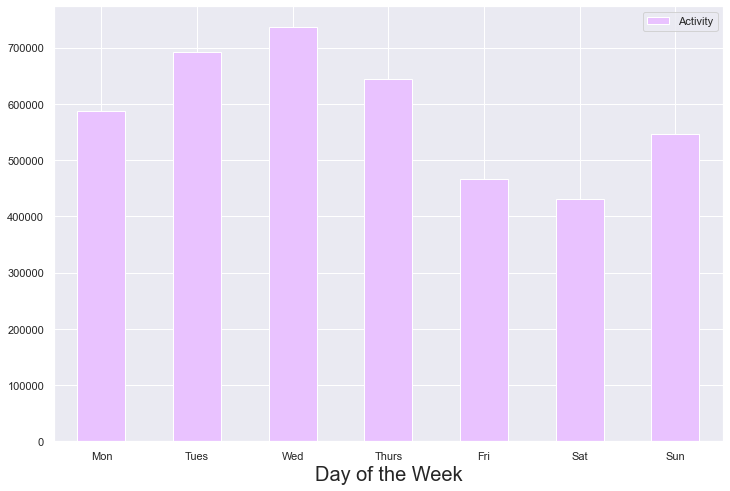

In [75]:
activity_week_day = []
weekDays = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]

for i in range(7): activity_week_day.append(((data['weekday'] == weekDays[i]) ).sum())
    
activity_week_day_df = pd.DataFrame(activity_week_day ,index=weekDays)
activity_week_day_df = activity_week_day_df.reset_index()
activity_week_day_df.columns = ['Day of the Week', 'Activity']

ax = activity_week_day_df.plot.bar(x='Day of the Week', y='Activity', rot=0, color ="#e9c2ff", figsize=(12, 8))

Figure 3.0.a - Activity (cart, remove_from_basket, purchase and view) by day of the week

This figure illustrates that the most number of activity on the cosmetic e-commerce website happens on Wednesday and the least happens on Saturday. This is interesting as I expected there to be more activities during the weekend, as this would be a leasurely time for most people. 

In [77]:
#plotly to visualise funnel
data_funnel=data[data['event_type']!='remove_from_cart'].groupby(['event_type'],as_index=False)['event_time'].count()
data_funnel.columns=['event_type','occurence']
data_funnel.sort_values('occurence', inplace=True,ascending=False)
data_funnel.reset_index(drop=True,inplace=True)
data_funnel['percent']=data_funnel['occurence']/(data_funnel['occurence'][0].sum())*100

fig = go.Figure(go.Funnel(
    y = data_funnel["event_type"],
    x = data_funnel["occurence"],
    customdata=data_funnel["percent"],
    texttemplate= "<b>%{label}: </B>%{value:.2s}"+"<br><b>% of total:</b> %{customdata:.2f}%",
    textposition='inside',
    marker = {"color": ["#ffe0fa", "#ffb5f3", "#e84dcf"]}))

fig.update_yaxes(visible=False)
fig.update_layout(template='simple_white',     
                  title={'xanchor': 'center',
                         'yanchor': 'top',        
                         'y':0.9,
                         'x':0.5,
                         'text':"Customer Funnel for Purchase Journey"})

Figure 3.0.b - Funnel diagram of customers purchase journey

Figure 3.0.b is as expected, there are significantly more views than there are purchases. View activities make up over 50% of the total activity in the OCtober 2019 dataset.

Text(0.5, 0, 'Days of the Week')

Text(0, 0.5, 'Number of Daily Activities')

Text(0.5, 1.0, 'Number of Daily Activities, October 2019')

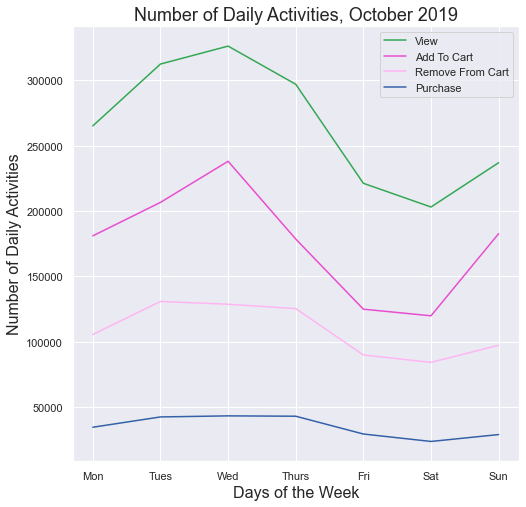

In [84]:
# Create for loop that 
casualty_month_year = [] 
eventType = ['view','remove_from_cart','cart','purchase']
for i in range (4): #iterating through event type
    for j in range (7): #iterating through days of the week
        casualty_month_year.append(((data['event_type'] == eventType[i]) & (data['weekday'] == weekDays[j])).sum())

        
b_array = np.array(casualty_month_year).reshape(4,7)
b_df = pd.DataFrame(b_array, columns = weekDays, index = eventType).T

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(b_df['view'], color = '#32a852', label = "View")
plt.plot(b_df['cart'], color = "#e84dcf", label = "Add To Cart")
plt.plot(b_df['remove_from_cart'], color = "#ffb5f3", label = "Remove From Cart")
plt.plot(b_df['purchase'], color = '#3261a8', label = "Purchase")

plt.legend(loc='best')
plt.xlabel("Days of the Week", fontsize=16)
plt.ylabel("Number of Daily Activities", fontsize=16)
plt.title("Number of Daily Activities, October 2019", fontsize=18)

Figure 3.0.c - Customer's daily activity by day of the week, by activity type

This figure is interesting because it generally reflects the activity trends in Figure 3.0.a, however there is a significant hike in the 'add to cart' activity on wednesday with non-significant increase in purchases or remove from cart. This can signify that large number of the users 'window shop' on wednesday.

In [83]:
data_hourly_activities=data.groupby(['hours','weeknum'],as_index=False)['price'].count()
data_hourly_activities.columns=['hours','weeknum','price']

#Visualisation
fig = px.area(data_hourly_activities, x='hours', y='price',color='weeknum',
              color_discrete_map={'1': '#32a852','2': '#3261a8', '3': '#a83259','4':'#ffe0fa', '5':'#ffb5f3'})

fig.update_layout(template='simple_white',     
                title={'xanchor': 'center','yanchor': 'top','y':0.9,'x':0.5,'text':"Customer's Weekly Website Activity by Hour"},
                
                xaxis = dict(
                    title_text='Hours',
                    tickmode = 'linear',
                    tick0 = 0,
                    dtick = 2),
                  
                yaxis = dict(
                    title_text='Visitors'))


Figure 3.0.d - Customer's weekly activity by hour

This figure illustrates that most activity on the website happens between lunch time between 10 - 12, and after work hours between 17 - 20

Text(0.5, 0, 'Day of the Month')

Text(0, 0.5, 'Number of Activities')

Text(0.5, 1.0, 'Number of Daily Activities by Activity Type, October 2019')

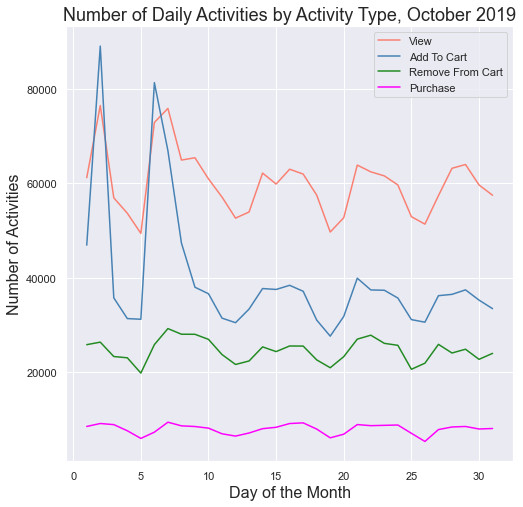

In [88]:
# Create for loop that 
casualty_month_year = [] 
weekNum = ['Week 1','Week 2','Week 3','Week 4','Week 5']
eventType = ['view','remove_from_cart','cart','purchase']
for i in range (4): #iterating through event type
    for j in range (31): #iterating through the week numbers
        casualty_month_year.append(((data['event_type'] == eventType[i]) & (data['day'] == (j+1))).sum())

b_array = np.array(casualty_month_year).reshape(4,31)
b_df = pd.DataFrame(b_array, columns = set(data['day']), index = eventType).T

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(b_df['view'], color = 'salmon', label = "View")
plt.plot(b_df['cart'], color = 'steelblue', label = "Add To Cart")
plt.plot(b_df['remove_from_cart'], color = 'forestgreen', label = "Remove From Cart")
plt.plot(b_df['purchase'], color = 'magenta', label = "Purchase")

plt.legend(loc='best')
plt.xlabel("Day of the Month", fontsize=16)
plt.ylabel("Number of Activities", fontsize=16)
plt.title("Number of Daily Activities by Activity Type, October 2019", fontsize=18)

plt.show()

Figure 3.0.e - Number of Daily Activities by Activity Type

It appears that there are a high number of add to cart and view between the 2nd of October and 6th of October. This can be attributed to a new marketing campaign, promotion or perhaps even a UI/UX testing on the website. 

<AxesSubplot:ylabel='None'>

Text(0.5, 1.0, 'Number of Activities by Time of Day & Days of Week October 2019')

Text(0.5, 66.5, 'Days of the Week')

Text(66.5, 0.5, 'Time of Day')

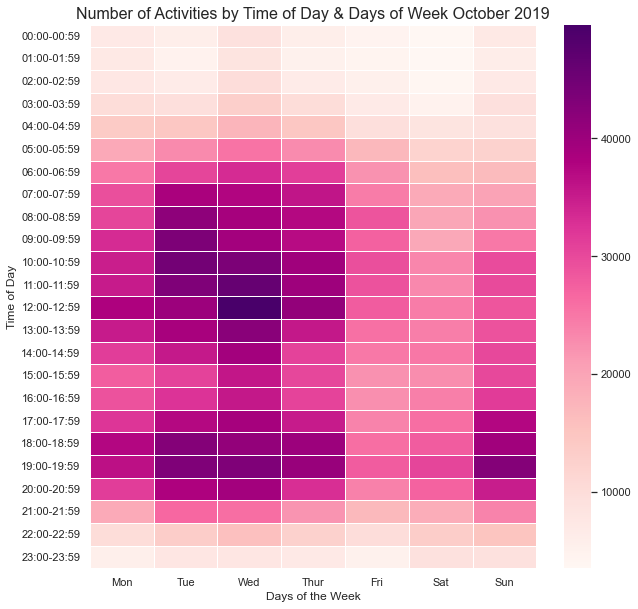

In [86]:
# Create variables with the desired axis tick values
time_intervals = ['00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59','06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59','12:00-12:59','13:00-13:59','14:00-14:59', '15:00-15:59','16:00-16:59','17:00-17:59','18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59']

#Empty list for for loop to append to
activity_day = [] 

for j in range (24): #iterating through hours of the day
    for i in range(7): #iterating through days of the week    
        activity_day.append(((data['hours'] == j) & (data['weekday'] == weekDays[i])).sum())

# Converts the list above into a shaped numpy array
activity_day_array = np.array(activity_day).reshape(24,7)

# Create a DataFrame with days of the week as columns and hour intervals as the index
df_activity_day = pd.DataFrame(activity_day_array, columns=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], index=[time_intervals])

# Set figure size
fig, ax = plt.subplots(figsize=(10,10))

# Use seaborn library to create heatmap of df_crash
sns.heatmap(df_activity_day, xticklabels=True, yticklabels=True, square=False, linewidths=0.6, cmap='RdPu')

# Use matplotlib library to label axis & provide title
plt.title("Number of Activities by Time of Day & Days of Week October 2019", fontsize = 16)
plt.xlabel("Days of the Week", fontsize = 12)
plt.ylabel("Time of Day", fontsize = 12)

Figure 3.0.f - Heatmap of activity by hour and day 

Figure 3.0.f highlight Figure 3.0.a and 3.0.c that many customers 'window shop' on a wednesday. This illustration also  specifies that the most number of activity happens on Wednesday between 12:00-12:59. It is also interesting to see that most of the activity also happens during work hours -perhaps this could imply that many of the customers enjoy browsing during work hours. 

## 4.0 RFM Analysis

In this section I will implement the RFM analysis by creating a new dataframe consisting of "Recency", "Frequency" and "Monetary". Recency will be calculated by subtracting the last day of the month (October 31st) with the day of the activity. Frequency will be calculated by counting occurences of a user_id and Monetary will be calculated by summing up the `price` of each user_id's activity. 

In [20]:
# Create DataFrame for Recency using day
data['Recency'] = 31 - data['day']
data_recency = data.groupby('user_id')['Recency'].min().reset_index().rename(columns={"0":"Recency"})
data_recency

user_id  Recency
0         4103071       10
1         8846226       29
2         9794320        8
3        10280338        4
4        10702733       16
...           ...      ...
399629  566279639        0
399630  566279883        0
399631  566279996        0
399632  566280278        0
399633  566280798        0

[399634 rows x 2 columns]

In [21]:
# Create DataFrame for Frequency
data_frequency=data.groupby('user_id')['event_type'].count().reset_index().rename(columns={"event_type":"Frequency"})
data_frequency

user_id  Frequency
0         4103071          8
1         8846226         47
2         9794320         20
3        10280338         82
4        10702733          2
...           ...        ...
399629  566279639          1
399630  566279883          1
399631  566279996          1
399632  566280278          4
399633  566280798          1

[399634 rows x 2 columns]

In [22]:
# Create DataFrame for Monetary
data_monetary=data.groupby('user_id')['price'].sum().reset_index().rename(columns={"price":"Monetary"})
data_monetary

user_id  Monetary
0         4103071     23.03
1         8846226    200.63
2         9794320     25.73
3        10280338    434.67
4        10702733     11.58
...           ...       ...
399629  566279639     10.95
399630  566279883     57.94
399631  566279996      9.37
399632  566280278     12.18
399633  566280798      4.13

[399634 rows x 2 columns]

In [23]:
# Merge the 3 dataframes created for recency, frequency and monetary
data_RF=pd.merge(data_recency,data_frequency,on='user_id')
data_RFM=pd.merge(data_RF,data_monetary,on='user_id')
data_RFM

user_id  Recency  Frequency  Monetary
0         4103071       10          8     23.03
1         8846226       29         47    200.63
2         9794320        8         20     25.73
3        10280338        4         82    434.67
4        10702733       16          2     11.58
...           ...      ...        ...       ...
399629  566279639        0          1     10.95
399630  566279883        0          1     57.94
399631  566279996        0          1      9.37
399632  566280278        0          4     12.18
399633  566280798        0          1      4.13

[399634 rows x 4 columns]

Now we split the metrics into segments using quantiles. We will assign a score from 1 to 4 to each Recency, Frequency and Monetary respectively. 1 is the highest value, and 4 is the lowest value. A final RFM score (Overall Value) is calculated simply by combining individual RFM score numbers.

In [24]:
quantiles = data_RFM.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [25]:
segmented_rfm = data_RFM.copy()

In [26]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [27]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm.head()

user_id  Recency  Frequency  Monetary  R_quartile  F_quartile  M_quartile
0   4103071       10          8     23.03           2           1           2
1   8846226       29         47    200.63           4           1           1
2   9794320        8         20     25.73           2           1           2
3  10280338        4         82    434.67           1           1           1
4  10702733       16          2     11.58           2           3           3

**Calculating the total RFM score combined**

RFM_Score = R_quartile + F_quartile + M_quartile

In [28]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+ segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)
        
segmented_rfm.head()

user_id  Recency  Frequency  Monetary  R_quartile  F_quartile  M_quartile  \
0   4103071       10          8     23.03           2           1           2   
1   8846226       29         47    200.63           4           1           1   
2   9794320        8         20     25.73           2           1           2   
3  10280338        4         82    434.67           1           1           1   
4  10702733       16          2     11.58           2           3           3   

  RFM_Segment  
0         212  
1         411  
2         212  
3         111  
4         233

In [29]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
segmented_rfm

user_id  Recency  Frequency  Monetary  R_quartile  F_quartile  \
0         4103071       10          8     23.03           2           1   
1         8846226       29         47    200.63           4           1   
2         9794320        8         20     25.73           2           1   
3        10280338        4         82    434.67           1           1   
4        10702733       16          2     11.58           2           3   
...           ...      ...        ...       ...         ...         ...   
399629  566279639        0          1     10.95           1           4   
399630  566279883        0          1     57.94           1           4   
399631  566279996        0          1      9.37           1           4   
399632  566280278        0          4     12.18           1           2   
399633  566280798        0          1      4.13           1           4   

        M_quartile RFM_Segment  RFM_Score  
0                2         212          5  
1                1         411          6  
2                2         212          5  
3                1         111          3  
4                3         233          8  
...            ...         ...        ...  
399629           3         143          8  
399630           2         142          7  
399631           3         143          8  
399632           3         123          6  
399633           4         144          9  

[399634 rows x 9 columns]

In [30]:
segmented_rfm['RFM_Segment'].min()
segmented_rfm['RFM_Segment'].max()

'111'

'444'

In [31]:
print("Best Customers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyal Customers: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Big Spenders: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Lost Cheap Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Best Customers:  27131
Loyal Customers:  92853
Big Spenders:  99771
Lost Cheap Customers:  15646


create visualisation
recenvy vs monetary etc.. 

In [32]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary       
             mean      mean     mean  count
RFM_Score                                  
3             2.8      66.4    492.2  27131
4             8.7      30.4    250.0  28748
5            13.1      18.0    164.5  30717
6            14.7       9.2    103.0  35116
7            14.9       3.1     52.7  43375
8            17.3       2.5     28.2  64161
9            15.4       1.9     14.4  72900
10           18.2       1.3      8.5  49109
11           22.9       1.1      5.6  32731
12           27.5       1.0      3.5  15646

## 5.0 Normalisation, Skew Test and Models

As mentioned previously, in this report I will implement the following models:
1. DBSCAN
2. K-means
3. Gaussian Mixture Models (GMM)

Firstly, I will check the skew of the data and perform some log transformation and winsorizing to remove outliers that could shift clustering cetroids. After improving the 'skewness' of the data and applying winsorizing, I apply scaling and centring to the data. This will result in Recency, Frequency and Monetary to have a mean of 0 and standard deviation of 1.

In [33]:
# Creating a function to check the distribution of R, F and M and assess skewness level
def check_distribution(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Recency's: Skew: -0.09182466034065231, : SkewtestResult(statistic=-23.648950374607796, pvalue=1.2100350547076401e-123)


<AxesSubplot:>

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Frequency's: Skew: 17.820618504922862, : SkewtestResult(statistic=795.8780371456133, pvalue=0.0)


<AxesSubplot:>

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Monetary's: Skew: 19.91075461645519, : SkewtestResult(statistic=819.227056473524, pvalue=0.0)


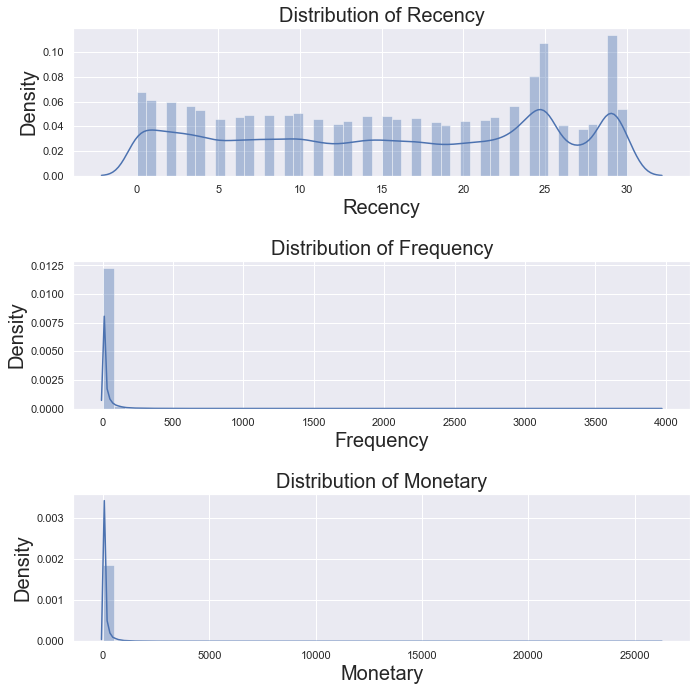

In [34]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
check_distribution(data_RFM,'Recency')

plt.subplot(3, 1, 2)
check_distribution(data_RFM,'Frequency')

plt.subplot(3, 1, 3)
check_distribution(data_RFM,'Monetary')

plt.tight_layout()

In [35]:
data_RFMlog = data_RFM.copy()

<Figure size 648x648 with 0 Axes>

<AxesSubplot:>

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Recency's: Skew: -1.2234045118839887, : SkewtestResult(statistic=-251.57785519234778, pvalue=0.0)


<AxesSubplot:>

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Frequency's: Skew: 1.8025886916400873, : SkewtestResult(statistic=323.01435609214826, pvalue=0.0)


<AxesSubplot:>

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Monetary's: Skew: 0.5703229902239096, : SkewtestResult(statistic=137.27526381683182, pvalue=0.0)


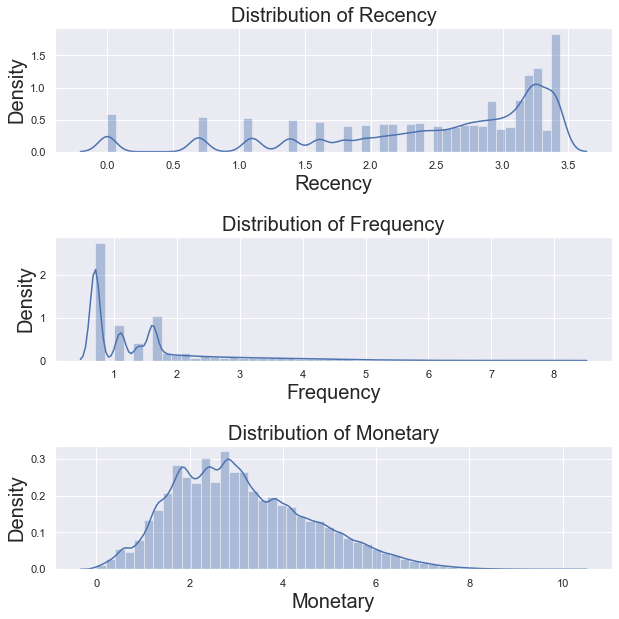

In [36]:
data_RFMlog = np.log(data_RFMlog +1)
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_distribution(data_RFMlog ,'Recency')
plt.subplot(3, 1, 2)
check_distribution(data_RFMlog ,'Frequency')
plt.subplot(3, 1, 3)
check_distribution(data_RFMlog ,'Monetary')

plt.tight_layout()

In [37]:
data_RFM.describe()

user_id       Recency      Frequency       Monetary
count  3.996340e+05  399634.00000  399634.000000  399634.000000
mean   5.288603e+08      15.51362      10.263456      87.600407
std    6.374382e+07       9.46069      39.190338     300.987835
min    4.103071e+06       0.00000       1.000000       0.000000
25%    5.295906e+08       7.00000       1.000000       6.350000
50%    5.571228e+08      16.00000       2.000000      17.760000
75%    5.607876e+08      24.00000       4.000000      60.320000
max    5.662808e+08      30.00000    3965.000000   26211.440000

In [38]:
windsoriser = Winsorizer(tail='both', # cap both tails 
                          fold=2,variables=[ 'Recency', 'Frequency', 'Monetary'])

windsoriser.fit(data_RFMlog)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [39]:
data_RFMlog = windsoriser.transform(data_RFMlog)

<Figure size 648x648 with 0 Axes>

<AxesSubplot:>

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Recency's: Skew: -0.9417917207877348, : SkewtestResult(statistic=-207.74159090500186, pvalue=0.0)


<AxesSubplot:>

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Frequency's: Skew: 1.2120432454823848, : SkewtestResult(statistic=249.94486380130346, pvalue=0.0)


<AxesSubplot:>

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Monetary's: Skew: 0.3737220020211455, : SkewtestResult(statistic=93.36739896667255, pvalue=0.0)


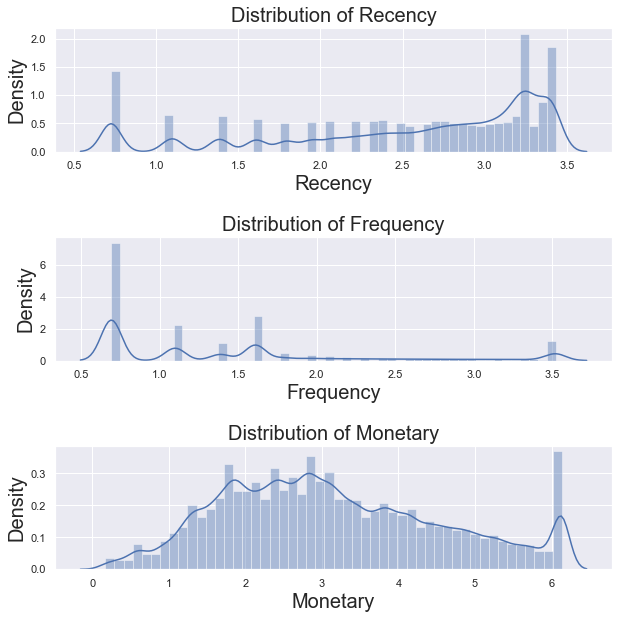

In [40]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_distribution(data_RFMlog ,'Recency')
plt.subplot(3, 1, 2)
check_distribution(data_RFMlog ,'Frequency')
plt.subplot(3, 1, 3)
check_distribution(data_RFMlog ,'Monetary')

plt.tight_layout()

In [41]:
scaler = StandardScaler()
scaler.fit(data_RFMlog)
data_RFMscaled = scaler.transform(data_RFMlog)

data_RFMscaled = pd.DataFrame(data_RFMscaled, columns=data_RFMlog.columns)
data_RFMscaled.head(10)

StandardScaler()

user_id   Recency  Frequency  Monetary
0 -29.857539 -0.187408   0.905086  0.036522
1 -25.126571  1.034660   2.432224  1.523448
2 -24.499608 -0.431834   1.882707  0.110957
3 -24.201369 -1.147785   2.432224  2.062015
4 -23.953409  0.342829  -0.362505 -0.415886
5 -23.802400 -1.769994  -0.362505  0.136883
6 -23.220283  0.268986  -0.362505 -0.781165
7 -22.577112  0.540785  -0.830335 -0.584061
8 -22.572964 -1.147785   1.026652  0.514916
9 -22.264045  0.412451  -0.830335 -1.220347

### 5.1 DBSCAN

For my first clustering model, I will implement DBSCAN clustering into my RFM dataset. Although DBSCAN is often referred to as the best clustering algorithm for skewed data, I remain implementing it on my scaled data because on my initial try, I implemented it on an unscaled data and the results were very unclear and un-plot-able. 


For the parameters to fit the dataset, I decided to follow the method discussed by Schubert et. al - which is dim*2 (Schubert et al, 2017). Hence, as I have 3 dimensions, I will choose 6. As for the epsilon value, I determined it using the nearest neighbors (Mullin, 2020). From the nearest neighbor graph below, I can see that the highest curvature point is between 0.2 - 0.3.

In [42]:
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(data_RFMscaled)
distances, indices = neighbors_fit.kneighbors(data_RFMscaled)

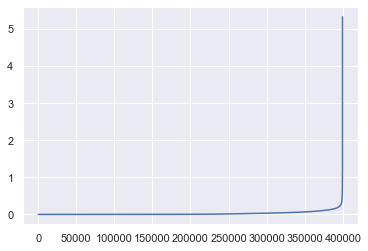

In [43]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [44]:
# DBSCAN Model 1 - eps = 0.3
data_RFMscaled_db = data_RFMscaled.copy()
data_RFMscaled_db = data_RFMscaled_db.drop(columns='user_id')

dbmodel = DBSCAN(eps = 0.3, min_samples = 6, n_jobs=-1)
dbmodel.fit(data_RFMscaled_db.iloc[:,:3])
data_RFMscaled_db['db_clusters'] = dbmodel.labels_

DBSCAN(eps=0.3, min_samples=6, n_jobs=-1)

In [45]:
data_RFMscaled_db.db_clusters.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, -1,  9])

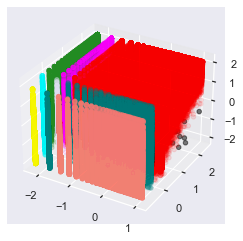

In [46]:
db0 = data_RFMscaled_db[data_RFMscaled_db['db_clusters']==0]
db1 = data_RFMscaled_db[data_RFMscaled_db['db_clusters']==1]
db2 = data_RFMscaled_db[data_RFMscaled_db['db_clusters']==2]
db3 = data_RFMscaled_db[data_RFMscaled_db['db_clusters']==3]
db4 = data_RFMscaled_db[data_RFMscaled_db['db_clusters']==4]
db5 = data_RFMscaled_db[data_RFMscaled_db['db_clusters']==5]
db6 = data_RFMscaled_db[data_RFMscaled_db['db_clusters']==6]
db7 = data_RFMscaled_db[data_RFMscaled_db['db_clusters']==7]
db8 = data_RFMscaled_db[data_RFMscaled_db['db_clusters']==8]
db9 = data_RFMscaled_db[data_RFMscaled_db['db_clusters']==9]
out = data_RFMscaled_db[data_RFMscaled_db['db_clusters']==-1]

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(db0.iloc[:,0],db0.iloc[:,1],db0.iloc[:,2], color = 'red', alpha=0.1)
ax.scatter(db1.iloc[:,0],db1.iloc[:,1],db1.iloc[:,2], color = 'teal', alpha=0.1)
ax.scatter(db2.iloc[:,0],db2.iloc[:,1],db2.iloc[:,2], color = 'lavender', alpha=0.1)
ax.scatter(db3.iloc[:,0],db3.iloc[:,1],db3.iloc[:,2], color = 'salmon', alpha=0.1)
ax.scatter(db4.iloc[:,0],db4.iloc[:,1],db4.iloc[:,2], color = 'forestgreen', alpha=0.1)
ax.scatter(db5.iloc[:,0],db5.iloc[:,1],db5.iloc[:,2], color = 'teal', alpha=0.1)
ax.scatter(db6.iloc[:,0],db6.iloc[:,1],db6.iloc[:,2], color = 'magenta', alpha=0.1)
ax.scatter(db7.iloc[:,0],db7.iloc[:,1],db7.iloc[:,2], color = 'yellow', alpha=0.1)
ax.scatter(db8.iloc[:,0],db8.iloc[:,1],db8.iloc[:,2], color = 'aqua', alpha=0.1)
ax.scatter(db9.iloc[:,0],db9.iloc[:,1],db9.iloc[:,2], color = 'lavender', alpha=0.1)
ax.scatter(out.iloc[:,0],out.iloc[:,1],out.iloc[:,2], color = 'black', alpha=0.5)

Figure 5.1.a  -  DBSCAN scatter plot with epsilon 0.3

In [47]:
#DBSCAN Model 2 - eps =  0.2
data_RFMscaled_db2 = data_RFMscaled.copy()
data_RFMscaled_db2 = data_RFMscaled_db2.drop(columns='user_id')

dbmodel2 = DBSCAN(eps = 0.2, min_samples = 6, n_jobs=-1)
dbmodel2.fit(data_RFMscaled_db2.iloc[:,:3])
data_RFMscaled_db2['db_clusters'] = dbmodel2.labels_

DBSCAN(eps=0.2, min_samples=6, n_jobs=-1)

In [48]:
data_RFMscaled_db2.db_clusters.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, -1])

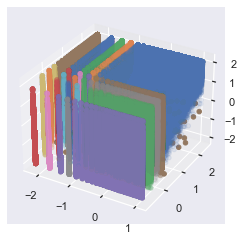

In [49]:
db0 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==0]
db1 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==1]
db2 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==2]
db3 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==3]
db4 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==4]
db5 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==5]
db6 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==6]
db7 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==7]
db8 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==8]
db9 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==9]
db10 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==10]
db11 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==11]
db12 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==12]
db13 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==13]
db14 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==14]
db15 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==15]
db16 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==16]
db17 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==17]
db18 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==18]
db19 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==19]
db20 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==20]
db21 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==21]
db22 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==22]
db23 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==23]
db24 = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==24]
out = data_RFMscaled_db2[data_RFMscaled_db2['db_clusters']==-1]

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(db0.iloc[:,0],db0.iloc[:,1],db0.iloc[:,2], alpha=0.1)
ax.scatter(db1.iloc[:,0],db1.iloc[:,1],db1.iloc[:,2], alpha=0.1)
ax.scatter(db2.iloc[:,0],db2.iloc[:,1],db2.iloc[:,2], alpha=0.1)
ax.scatter(db3.iloc[:,0],db3.iloc[:,1],db3.iloc[:,2], alpha=0.1)
ax.scatter(db4.iloc[:,0],db4.iloc[:,1],db4.iloc[:,2], alpha=0.1)
ax.scatter(db5.iloc[:,0],db5.iloc[:,1],db5.iloc[:,2], alpha=0.1)
ax.scatter(db6.iloc[:,0],db6.iloc[:,1],db6.iloc[:,2], alpha=0.1)
ax.scatter(db7.iloc[:,0],db7.iloc[:,1],db7.iloc[:,2], alpha=0.1)
ax.scatter(db8.iloc[:,0],db8.iloc[:,1],db8.iloc[:,2], alpha=0.1)
ax.scatter(db9.iloc[:,0],db9.iloc[:,1],db9.iloc[:,2], alpha=0.1)
ax.scatter(db10.iloc[:,0],db10.iloc[:,1],db10.iloc[:,2], alpha=0.1)
ax.scatter(db11.iloc[:,0],db11.iloc[:,1],db11.iloc[:,2], alpha=0.1)
ax.scatter(db12.iloc[:,0],db12.iloc[:,1],db12.iloc[:,2], alpha=0.1)
ax.scatter(db13.iloc[:,0],db13.iloc[:,1],db13.iloc[:,2], alpha=0.1)
ax.scatter(db14.iloc[:,0],db14.iloc[:,1],db14.iloc[:,2], alpha=0.1)
ax.scatter(db15.iloc[:,0],db15.iloc[:,1],db15.iloc[:,2], alpha=0.1)
ax.scatter(db16.iloc[:,0],db16.iloc[:,1],db16.iloc[:,2], alpha=0.1)
ax.scatter(db17.iloc[:,0],db17.iloc[:,1],db17.iloc[:,2], alpha=0.1)
ax.scatter(db18.iloc[:,0],db18.iloc[:,1],db18.iloc[:,2], alpha=0.1)
ax.scatter(db19.iloc[:,0],db19.iloc[:,1],db19.iloc[:,2], alpha=0.1)
ax.scatter(db20.iloc[:,0],db20.iloc[:,1],db20.iloc[:,2], alpha=0.1)
ax.scatter(db21.iloc[:,0],db21.iloc[:,1],db21.iloc[:,2], alpha=0.1)
ax.scatter(db22.iloc[:,0],db22.iloc[:,1],db22.iloc[:,2], alpha=0.1)
ax.scatter(db23.iloc[:,0],db23.iloc[:,1],db23.iloc[:,2], alpha=0.1)
ax.scatter(db24.iloc[:,0],db24.iloc[:,1],db24.iloc[:,2], alpha=0.1)
ax.scatter(out.iloc[:,0],out.iloc[:,1],out.iloc[:,2], alpha=1)

Figure 5.1.b - DBSCAN scatter plot with epsilon 0.2

By changing the epsilon value from 0.3 to 0.2 I got a clustering model that segregates the customer into more cluster. This finding is aligned with the epsilon theory discussed in the textbook. When epsilon is set to 0.3, what I essentially did is specifying the distance between the points, in a simplified defnition, points with distance 0.3 are clustered together (=10 clusters, Figure 5.1.a). However, when I set epsilon value to 0.2, the distance in which 2 points are to be clustered together, are reduced. Hence, more clusters are created (=25 clusters), as illustrated in Figure 5.1.b.

### Evaluation of DBSCAN: Business Perspective

After running the 2 DBSCAN clustering algorithms with epsilon 0.3 and 0.2, we saw that the scatter plot shows that the DBSCAN with epsilon 0.2 seems to be better clustered with a visibly tighter and clearer clusters. However, for a business application, we need to deepdive into what it means and how this information can be utilised.

In [50]:
data_RFMscaled_db3 = data_RFMscaled.copy()
data_RFMscaled_db3['db_clusters'] = data_RFMscaled_db['db_clusters']
data_RFMscaled_db3.db_clusters.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, -1,  9])

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Features', ylabel='Value'>

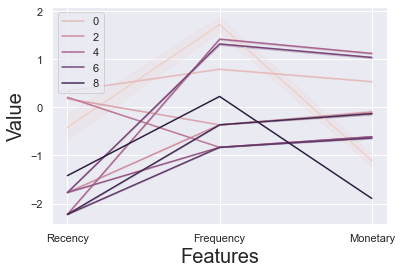

In [51]:
melted_db = pd.melt(data_RFMscaled_db3.reset_index(), id_vars=['user_id','db_clusters'], value_vars = ['Recency','Frequency','Monetary'],
                   var_name='Features', value_name = 'Value')
sns.lineplot('Features','Value', hue = 'db_clusters', data = melted_db)
plt.legend()

Figure 5.1.c - Line plot illustrating relationship between R, F and M within each DBSCAN cluster model 1 (eps=0.3)

In [52]:
data_RFMscaled_db4 = data_RFMscaled.copy()
data_RFMscaled_db4['db_clusters'] = data_RFMscaled_db2['db_clusters']
data_RFMscaled_db4.db_clusters.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, -1])

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Features', ylabel='Value'>

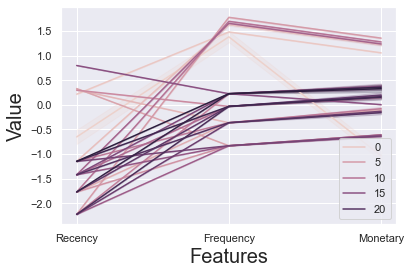

In [53]:
melted_db = pd.melt(data_RFMscaled_db4.reset_index(), id_vars=['user_id','db_clusters'], value_vars = ['Recency','Frequency','Monetary'],
                   var_name='Features', value_name = 'Value')
sns.lineplot('Features','Value', hue = 'db_clusters', data = melted_db)
plt.legend()

Figure 5.1.d - Line plot illustrating relationship between R, F and M within each DBSCAN cluster model 2 (eps=0.2)

At a glance, Figure 5.1.c is clearer than Figure 5.1.d and can be said to segment the customers fairly well. For instance, from figure 5.1.c, we can deduce that customers in cluster 4, 5 and 6 are quite simillar and are some of the best customers that the business have. We know this because the line plot suggests that these clusters have a low recency of between -1.8 to -2.1, a fairly high frequency score of about 1.4 and have the highest monetary score of 1. Customers within this cluster would most likely be considered as "loyal customers", and would not benefit much from mailing promotions. These customers would instead benefit from good customer service and personalisation service to make them feel acknowledged as a loyal customer. 

Despite the clarity that Figure 5.1.c gives, Figure 5.1.d could give businesses a more thorough breakdown of the clustering. For instance, if we look at the lowest frequency plot, there are 5 different lines coming to that plot from Recency. Although it looks messy, this informs businesses that there are different clusters of recency that have the same frequency. This is especially interesting in the case of this cosmetic e-commerce dataset because the products sold by this company are usually 'repeat-buy products' in different intervals, meaning that although some of the purchase are not recent, it can be attributed to the products; for instance, an individual purchases a makeup foundation every 2 months, hence, the dataset may capture the frequent customer that purchased items earlier in the month.

### 5.2 K-means

For the second clustering model, I chose K-means as it is one of the more popular clutering algorithm, hence I am inclined to implement this. 

As K-means clustering are said to perform better in an unskewed data, I have applied log transformation, winsorizing and scaling in section 5.0. Which leaves me with `data_RFMscaled` that contains Recency, Frequency and Monetary with a mean of 0 and a standard deviation of 1. To perform the K-means clustering, I will determine the K-value using 2 elbow methods; distortion and inertia -this is to confirm the K-value and perform hyperparameter tuning if there are a widely different result from the two methods. 

In [116]:
map1 = {} 
map2 = {}
distortion = [] 
inertia = []
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(data_RFMscaled) 
    kmeanModel.fit(data_RFMscaled)     
      
    distortion.append(sum(np.min(cdist(data_RFMscaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / data_RFMscaled.shape[0]) 
    inertia.append(kmeanModel.inertia_) 
  
    map1[k] = sum(np.min(cdist(data_RFMscaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / data_RFMscaled.shape[0] 
    map2[k] = kmeanModel.inertia_ 

KMeans(n_clusters=1)

KMeans(n_clusters=2)

KMeans(n_clusters=3)

KMeans(n_clusters=4)

KMeans(n_clusters=5)

KMeans(n_clusters=6)

KMeans(n_clusters=7)

KMeans()

KMeans(n_clusters=9)

Text(0.5, 0, 'Values of K')

Text(0, 0.5, 'Distortion')

Text(0.5, 1.0, 'The Elbow Method using Distortion')

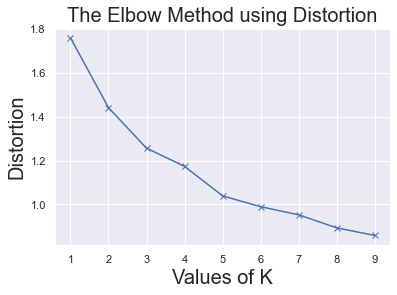

In [117]:
plt.plot(K, distortion, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

Figure 5.2.a - Determining optimum value of K using distortion

Text(0.5, 0, 'Values of K')

Text(0, 0.5, 'Inertia')

Text(0.5, 1.0, 'The Elbow Method using Inertia')

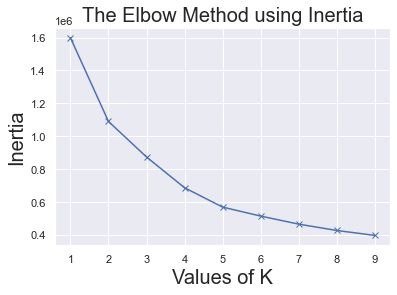

In [118]:
plt.plot(K, inertia, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

Figure 5.2.b - Determining optimum value of K using Inertia

From the results above, I can conclude that the optimal K value would be within the range of 4 - 6. These values are chosen as they are the point just before distortion and inertia are at a stagnant. The simple analogy for this selection is the number of cluster, where if one extra cluster is added, it would not reduce inertia and distortion by much.

In [119]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



<AxesSubplot:>

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



<AxesSubplot:>

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/var/folders/hg/qz_lhg353nx_d9rwb8v6sq3c0000gn/T/ipykernel_37440/4036872160.py:12: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



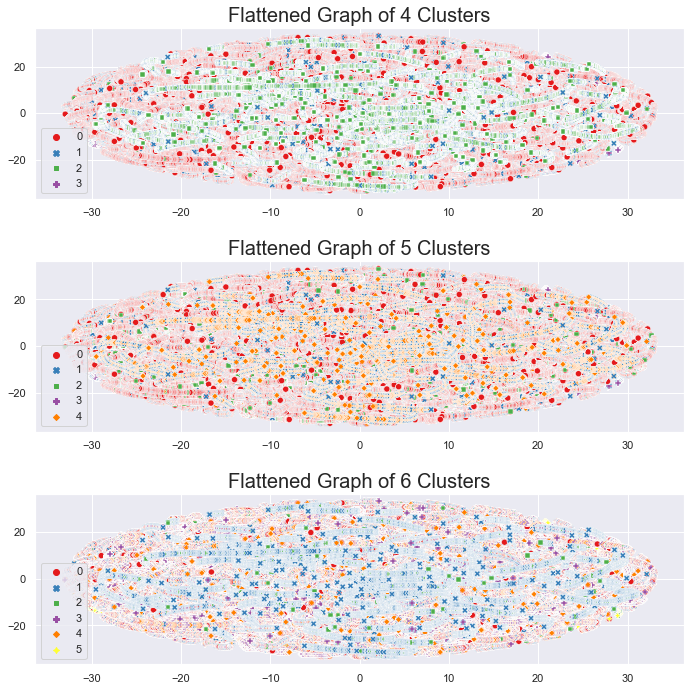

In [121]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k4 = kmeans(data_RFMscaled, 4, data_RFM)

plt.subplot(3, 1, 2)
df_rfm_k5 = kmeans(data_RFMscaled, 5, data_RFM)

plt.subplot(3, 1, 3)
df_rfm_k6 = kmeans(data_RFMscaled, 6, data_RFM)

plt.tight_layout()

Figure 5.2.c - Flattened Graph of the K-means model with K value of 4, 5 and 6, respectively. 

Figure 5.2.c doesn't really show much as there are an abundance of plots on the graph. It is really difficult to tell what is going on, but this is expected with a real-life data that is filled with noice and outliers. I will try to plot one of these into a 3D plot and see whether that will visualise the clustering better. Please note that I am unable to re-run the cell above as it took me a whole night to run (faculty and locally).

KMeans(n_clusters=5, random_state=1)

/var/folders/hg/qz_lhg353nx_d9rwb8v6sq3c0000gn/T/ipykernel_37440/836989526.py:27: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



Text(0.5, 0, 'Recency')

Text(0.5, 0.5, 'Frequency')

Text(0.5, 0, 'Monetary Value($)')

(-3.0, 2.0)

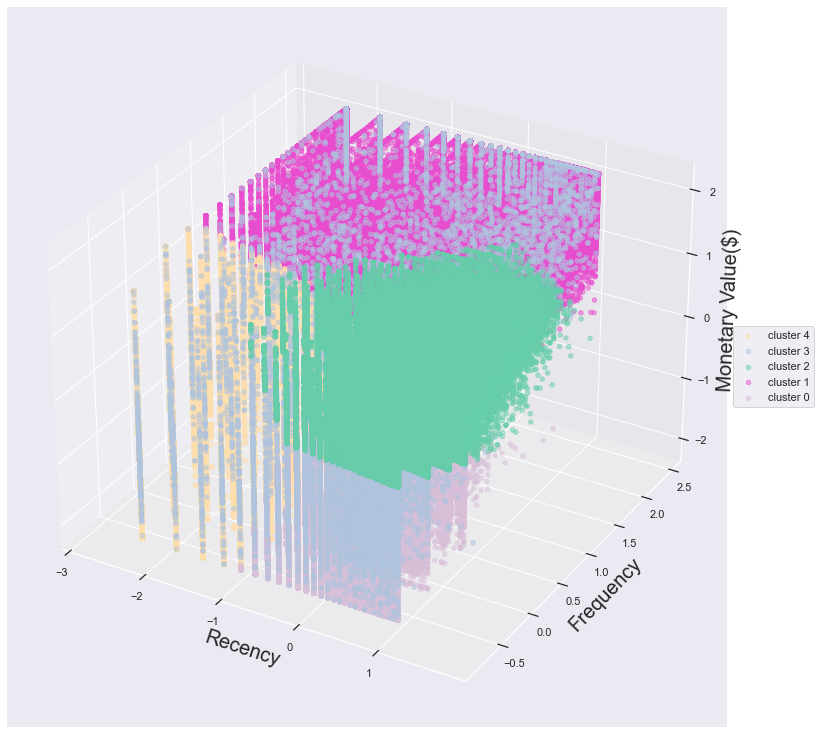

In [125]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles
data_RFM2=data_RFMscaled.drop(columns=['user_id'])
X = StandardScaler().fit_transform(data_RFMscaled)

# group customers into 5 clusters
random.seed(888)
km=KMeans(n_clusters=5,random_state=1)
km.fit(X)
random.seed(888)
pred=km.predict(X)
data_RFM2=data_RFM2.assign(clusters=pred)

# visualize the 4 clusters
R=[]
F=[]
M=[]
mycolors=['navajowhite','lightsteelblue','mediumaquamarine','#e84dcf','thistle','#3261a8']
cluster_orders=[4,3,2,1,0]
for i in [0,1,2,3,4]:
    R.append(data_RFM2.loc[data_RFM2.clusters==cluster_orders[i],'Recency'].values.tolist())
    F.append(data_RFM2.loc[data_RFM2.clusters==cluster_orders[i],'Frequency'].values.tolist())
    M.append(data_RFM2.loc[data_RFM2.clusters==cluster_orders[i],'Monetary'].values.tolist())
    
# 3D scatter plot
fig=plt.figure(figsize=(10,10))
ax=Axes3D(fig)
for i in [0,1,2,3,4]:
    ax.scatter(R[i], F[i], M[i], c=mycolors[i], marker='o',alpha=0.5,label='cluster '+str(cluster_orders[i]))
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value($)')
ax.set_xlim(-3,2)
ax.set_xticks(list(range(-3,2)))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Evaluation of K-means: Business Perspective

Similar to the DBSCAN model, I will try to plot the model into a snake plot to make sense of the mdel and its business application.

In [126]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, index=data_RFM.index,columns=data_RFM.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['user_id', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

<Figure size 648x648 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Snake Plot of K-Means = 4')

<AxesSubplot:>

Text(0.5, 1.0, 'Snake Plot of K-Means = 5')

<AxesSubplot:>

Text(0.5, 1.0, 'Snake Plot of K-Means = 6')

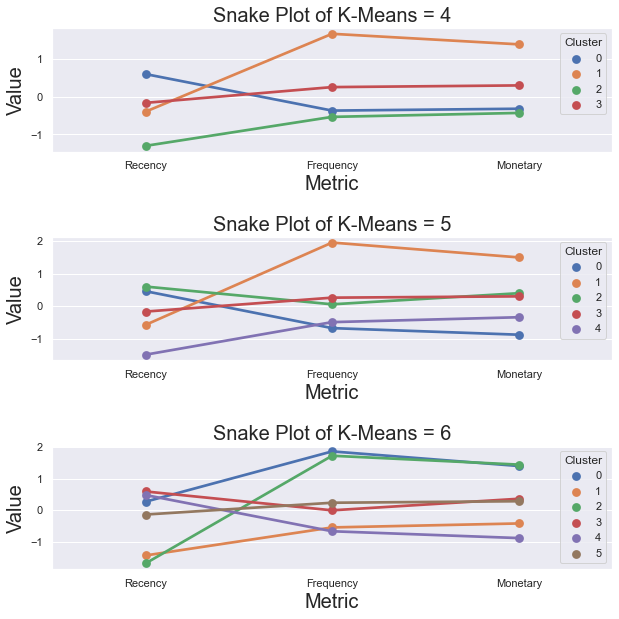

In [128]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 4')
snake_plot(data_RFMscaled, df_rfm_k4, data_RFM)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 5')
snake_plot(data_RFMscaled, df_rfm_k5, data_RFM)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 6')
snake_plot(data_RFMscaled, df_rfm_k6, data_RFM)

plt.tight_layout()

From the snake plots it is evident that having a cluster value of 4 segments the customers quite well with minimum overlapping. I think it would be interesting to see whether K=3 will perform a clearer segmentation as it appears that K=5 and K=6 both shows large amount of overlapping. Despite that, the usability of a model can only be fully determined by the business, if a business aims to create a highly personalised segmentation, then a higher value of K would satisfy that need. 

From a business perspective, when looking at k-means where K=4, the segment with best customer would be cluster 1 as it has low recency, high frequency and high monetary value. In terms of worst customer, it would be cluster 0. Using the K=4 model, we can see a cluster with "new customers" denoted as cluster 2. These customers are recent purchaser with low frequency (assumed because they are new) and low monetary. This cluster tend to benfit from promotions in order to get them accustomed to being a customer of the company. 

### 5.3 Gaussian-Mixture Model

In a GMM, it is important to run an Adequacy test before building the model as the GMM method takes importance over 'factorability' (Hanh, 2020). Hence, 2 tests will be done before we fit the model:

1. Bartlett's Test: Sphericity test to check whether variables are intercorrelated
2. Kaiser-Meyer-Olkin Test: estimates proportion of variance in the variables, KMO < 0.6 is bad

In [60]:
# Bartlett's Test
data_RFMscaled_gmm = data_RFMscaled.copy().drop(columns='user_id')
chi_square_value,p_value=calculate_bartlett_sphericity(data_RFMscaled_gmm)
chi_square_value,p_value

(284490.38910570537, 0.0)

As the p-value is less than 0.05, it means that my data is statistically significant and that a form of correlation is present among the variables with a 95% confidence level.

In [61]:
#KMO
kmo_all,kmo_model=calculate_kmo(data_RFMscaled_gmm)
kmo_model

0.5156127221320571

KMO is observed to be 0.09 lower than the 'good' value. Meaning that it is not too suitable for factor analysis. Despite that, I am still curious and motivated to learn how GMM clustering will perform on my dataset. Hence, I will still implement a GMM model on the data. 

In [62]:
# eigenvector
fa = FactorAnalyzer()
fa.fit(data_RFMscaled)
eigen_values, vectors = fa.get_eigenvalues()
x = np.arange(1,data_RFMscaled.shape[1]+1)


x = np.arange(10)
fig = go.Figure(data=go.Scatter(x=x, y=eigen_values))
fig.update_layout(title='Eigen value by number of factors',
                   xaxis_title='Factors',
                   yaxis_title='eigen_values')

FactorAnalyzer(rotation_kwargs={})

Figure 5.3.a - Eigen Values

At this point I am starting to think that maybe 3 factors (R,F and M) is too low for a GMM clustering because only less than 1 factor is above 1 in the eigen value. Furthermore, looking at examples from the textbook and online resources, I noticed that they all have at least 15 factors. However, I am still keen on implementing this, so I checked for factor loading. This matrix shows correlation and relationships between variables to the underlying factor. It also shows variances in the observes variabbles, hence, the greater the value, the higher the relationship between factor and variables.

In [63]:
fa.set_params(n_factors=3, rotation='varimax')
fa.fit(data_RFMscaled_gmm)
loadings = fa.loadings_
factor_loading = pd.DataFrame(loadings)
factor_loading

fa.get_factor_variance()
factor_variance = pd.DataFrame(fa.get_factor_variance())
factor_variance

FactorAnalyzer(rotation='varimax', rotation_kwargs={})

FactorAnalyzer(rotation='varimax', rotation_kwargs={})

0         1    2
0 -0.084900 -0.162913  0.0
1  0.768876  0.341488  0.0
2  0.738278  0.408512  0.0

(array([1.14343233, 0.3100367 , 0.        ]),
 array([0.38114411, 0.10334557, 0.        ]),
 array([0.38114411, 0.48448968, 0.48448968]))

0         1        2
0  1.143432  0.310037  0.00000
1  0.381144  0.103346  0.00000
2  0.381144  0.484490  0.48449

In [64]:
fa_finnal = FactorAnalyzer(n_factors=10, rotation="varimax")
fa_finnal.fit(data_RFMscaled_gmm)

FactorAnalyzer(n_factors=10, rotation='varimax', rotation_kwargs={})

In [65]:
col_name = []
for i in range(3): 
    col_name.append('Factor '+str(i+1))
df_factors = fa_finnal.transform(data_RFMscaled_gmm)
df_factors = pd.DataFrame(df_factors, columns = col_name)

df_factors

Factor 1  Factor 2  Factor 3
0       0.457682  0.121704       0.0
1       1.827126  0.621938       0.0
2       0.964665  0.269095       0.0
3       1.982157  1.034675       0.0
4      -0.333528 -0.208170       0.0
...          ...       ...       ...
399629 -0.644849  0.013837       0.0
399630 -0.208220  0.375884       0.0
399631 -0.683651 -0.018337       0.0
399632 -0.094531  0.140513       0.0
399633 -0.876223 -0.178015       0.0

[399634 rows x 3 columns]

In [66]:
def gmm_bic(a, lower=1, upper=4):
    bic = []
    for i in tqdm(range(lower,upper)):
        gm = GaussianMixture(n_components=i, covariance_type="full",max_iter=300, random_state=42)
        gm.fit(a)
        b = gm.bic(a)
        bic.append(b)
        print('Convergence? {} at iteration {}'.format(gm.converged_, gm.n_iter_))
    fig = go.Figure(data=go.Scatter(x=np.arange(lower,upper), y=bic))
    fig.update_layout(title='BIC',
                   xaxis_title='Numbe of Clusters',
                   yaxis_title='BIC')
    fig.show()

In [67]:
gmm_bic(data_RFMscaled_gmm)

 33%|███████████████                              | 1/3 [00:00<00:00,  2.35it/s]

Convergence? True at iteration 2


 67%|██████████████████████████████               | 2/3 [00:02<00:01,  1.34s/it]

Convergence? True at iteration 9


100%|█████████████████████████████████████████████| 3/3 [00:08<00:00,  2.81s/it]

Convergence? True at iteration 22


Figure 5.3.b - Optimal number of clusters under the BIC method

Using Bayesian Information Criterion, I find the number of clusters. I selected 3 because the general rule is that the lower the BIC, the better the model would predict the feeded data. As the graph above shows that the lowest BIC is 3 clusters, I will be using that.

In [68]:
modelgmm = GaussianMixture(n_components=3, max_iter=300, random_state=1)
modelgmm.fit(df_factors)
data_RFMscaled_gmm['Segment'] = modelgmm.predict(df_factors)

GaussianMixture(max_iter=300, n_components=3, random_state=1)

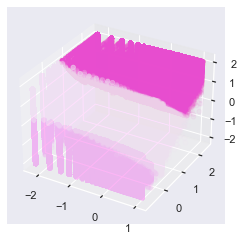

In [69]:
gmm0 = data_RFMscaled_gmm[data_RFMscaled_gmm['Segment']==0]
gmm1 = data_RFMscaled_gmm[data_RFMscaled_gmm['Segment']==1]
gmm2 = data_RFMscaled_gmm[data_RFMscaled_gmm['Segment']==2]

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(gmm0.iloc[:,0],gmm0.iloc[:,1],gmm0.iloc[:,2], color = "#ffe0fa", alpha=0.05)
ax.scatter(gmm1.iloc[:,0],gmm1.iloc[:,1],gmm1.iloc[:,2], color = "#ffb5f3", alpha=0.05)
ax.scatter(gmm2.iloc[:,0],gmm2.iloc[:,1],gmm2.iloc[:,2], color = "#e84dcf", alpha=0.05)

Figure 5.3.c - Scatter plot of GMM model

### Evaluation of GMM: Business Perspective

In [70]:
gmm_segment = pd.DataFrame(data_RFMscaled_gmm.groupby('Segment').size(), columns = ['# of customers'])
gmm_segment

gmm_segment_1 = data_RFMscaled.copy()
gmm_segment_1['Segment'] = data_RFMscaled_gmm['Segment']
gmm_segment_1

# of customers
Segment                
0                172770
1                162959
2                 63905

user_id   Recency  Frequency  Monetary  Segment
0      -29.857539 -0.187408   0.905086  0.036522        0
1      -25.126571  1.034660   2.432224  1.523448        2
2      -24.499608 -0.431834   1.882707  0.110957        2
3      -24.201369 -1.147785   2.432224  2.062015        2
4      -23.953409  0.342829  -0.362505 -0.415886        0
...           ...       ...        ...       ...      ...
399629   0.485433 -2.224329  -0.830335 -0.451800        1
399630   0.485436 -2.224329  -0.830335  0.663703        0
399631   0.485437 -2.224329  -0.830335 -0.550932        1
399632   0.485440 -2.224329   0.226891 -0.383316        0
399633   0.485446 -2.224329  -0.830335 -1.042916        1

[399634 rows x 5 columns]

/Users/ziva/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Factors', ylabel='Value'>

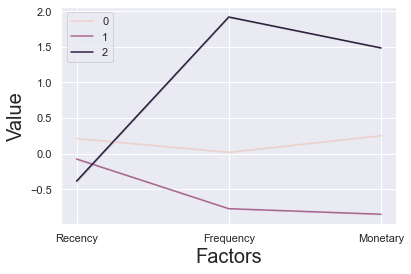

In [71]:
melted_gmm = pd.melt(gmm_segment_1.reset_index(), id_vars=['user_id','Segment'],
                     value_vars = ['Recency','Frequency','Monetary'],
                     var_name='Factors', value_name = 'Value')
sns.lineplot('Factors','Value', hue = 'Segment', data = melted_gmm)
plt.legend()

Figure 5.3.d - line plot for relationship between Recency, Frequency and Monetary for each cluster

Immediately, the lineplot in Figure 5.3.d looks better and have a higher readability than the lineplots in part 5.1 and 5.2. Furthermore, the scatter plot in figure 5.3.c seems to segment the customers well and with comparable number of customers in each cluster. From the scatter plot, we can see that Recency is not very segmented, with all cluster almost including the whole range of recency. However, Frequency and Monetary is well segmented: 
1. cluster 0 consisting of high monetary and high frequency customers: 172770 customers
2. cluster 1 consisting of medium to high monetary and medium to low frequency: 162595 customers
3. cluster 2 consisting of medium to low monetary and low frequency: 63905 customers

### 5.4 Evaluation of the Models: Silhouette Score

In this section I aim to evaluate the performance fo my models by using the silhouette score test. The silhouette score ranges from values of -1 to 1, whereby:
- 1: The clusters are well apart
- 0: The clusters are indifferent or insignificant
- -1: The clusters are assigned in the wrong way

Due to the long running time of the silhouette score arising from the size of my data, I had coded them in Appendix A and recorded the results here. Unfortunately, due to the long running time (1 silhouette score taking approximately 2 hours to run) I was only able to run it for the DBSCAN model 1 and 2 and the GMM.

|**Model**   |  **Silhouette Score**  |
|:---| :---|
| **`DBSCAN Model 1`** | 0.3221272525182396 |
| **`DBSCAN Model 2`** | 0.48964249154862094 |
| **`GMM`** | 0.38651928141844205 |

Although missing silhouette score from K-means I think it is fair to assume that the k-means silhouette score would be within the similar range as the table above. It is interesting to see that the highest score is obtained by DBSCAN model 2 where I changed the epsilon parameters into a value of 0.2 from 0.3 in DBSCAN model 1. It would definitely be interesting to see whether an even lower epsilon parameter would lead to a higher silhouette score. Furthermore, Despite GMM model plotting being the 'cleanest' looking, with easily interpretable results, it did not score the highest silhouette score. 

## 6.0 Conclusion

To conclude, none of the three clustering methods clustered the dataset perfectly well. Evaluating based on thevisualisation of the clustering, the distances between each cluster are visibly very close and have no immediate visible gaps between the clusters. This problem arises as the dataset is a large real-life dataset that is prone to noise and outliers. Furthermore, more hyperparameter tuning is needed in order to make unsupervised clustering ML work to a reliable standard. Despite that, I think the results of the modelling still provides an insight into the customer segments and can still be utilised within a business context, as I have done within the main body of this project.

Furthermore, the silhouette score supports my statement that the dataset is not clustered perfectly well, as the models similarly have a low silhouette score meaning that clustering is insignificant.

### 6.1 Limitations and Future Improvements

The main limitation and obstacle I face in this project is compute power. I initially have datasets for 5 months; October19, November19, December19, January20, February20 - totalling to 20.5 million rows. However, having tried to process the entire dataset on faculty and on my local machine - with no luck - I have decided to choose only one month that potentially do not have seasonality effect. Furthermore, attempting to evaluate the models using silhouette score was close to impossible as i had left running for over 5 hours, but no result show. This led me to interrupting the kernel for the K-means silhouette score(Appendix A: Attempt on Silhouette Score).

Lastly, I would really like to apply Ensemble and see whether it clusters RFM better. However, the package `Clustering_Ensembles` is current not working due to "conflicting dependencies". After sometime spent doing further research on other methods to apply ensemble on clustering algorithms, I still couldn't find any other clustering ensemble package -as sklearn do not have it either.

For future improvements, I would attempt to do more hyperparameter tuning on the models to see how it improves or worsen with each parameter change.

## References

Hanh, N., 2020. Buiding customer segmentation by GMM from scratch. Medium. Available at: https://nguyenbaha.medium.com/buiding-customer-segmentation-by-gmm-from-scratch-4ea6adc3da1c [Accessed March 1, 2022].

Schubert, E. et al., 2017. DBSCAN Revisited, revisited. ACM Transactions on Database Systems, 42(3), pp.1–21. 

Segal, T., 2021. Recency, frequency, monetary value (RFM) definition. Investopedia. Available at: https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp [Accessed February 20, 2022]. 

Mullin, T., 2020. DBSCAN parameter estimation using Python. Medium. Available at: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd [Accessed February 24, 2022]. 

## Appendix A

This appendix is an attempt at implementing silhouette score and silhouette visualiser on all the models that created previously. This silhouette score have been left running for about 5/6 hours but unfortunately, I have to interrupt it and continue with my project.  

#### Silhouette Score for K-means

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=100, n_clusters=4,
                                      random_state=42))

KeyboardInterrupt: 

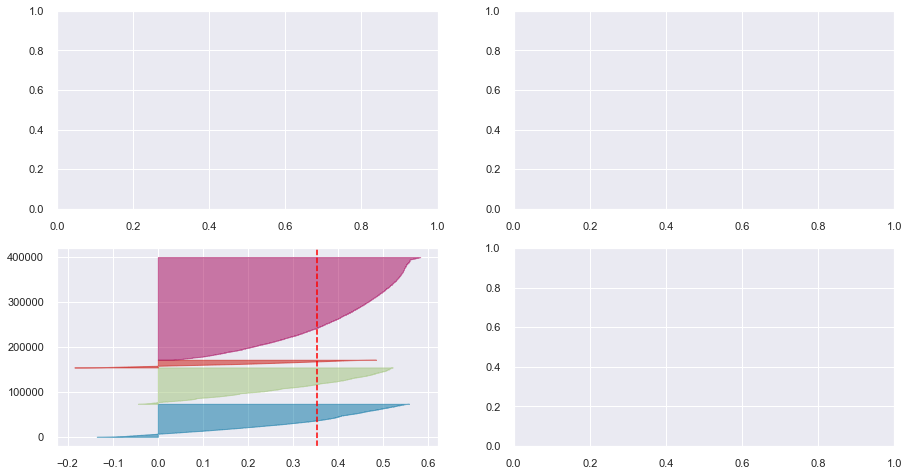

In [153]:
# Silhouette Score for K-means
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [4, 5, 6]:
 
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

#### Silhouette Score for DBSCAN

In [57]:
silhouette_score(data_RFMscaled_db, data_RFMscaled_db['db_clusters'])

0.3221272525182396

In [58]:
silhouette_score(data_RFMscaled_db2, data_RFMscaled_db2['db_clusters'])

0.48964249154862094

#### Silhouette Score for K-means

In [ ]:
silhouette_score(df_rfm_k4, df_rfm_k4['clusters'])

In [ ]:
silhouette_score(df_rfm_k5, df_rfm_k5['clusters'])

In [ ]:
silhouette_score(df_rfm_k6, df_rfm_k6['clusters'])

#### Silhouette Score for GMM

In [72]:
silhouette_score(data_RFMscaled_gmm, data_RFMscaled_gmm['Segment'])

0.38651928141844205